In [1]:
import pandas as pd
import tensorflow
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

2021-11-08 14:16:48.565150: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-08 14:16:48.565192: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_excel("data train.xlsx")

In [3]:
df['sentiment'] = df['sentiment'].fillna(value=2)
df['sentiment'] = df['sentiment'].astype(int)
df['text'] = df['text'].replace('\s+', ' ', regex=True)
df['text'] = df['text'].fillna('').apply(str)
df['text'] = df['text'].replace({'"':'',
                                 '\d+':'',
                                 ':':'',
                                 ';':'',
                                 '#':'',
                                 '@':'',
                                 '_':'',
                                 ',': '',
                                 "'": '',
                                  }, regex=True)

df['text'] = df['text'].str.replace(r'[https]+[?://]+[^\s<>"]+|www\.[^\s<>"]+[?()]+[(??)]+[)*]+[(\xa0]+[-&gt...]', "",regex=True)

df['text'] = df['text'].replace('\n','', regex=True)

df['text'] = df['text'].replace({'\.':'','(/)':'','\(':'','\)':''},regex=True)
df['text'] = df['text'].replace('[\.:"]','',regex =True)

df['text'] = df['text'].fillna('').apply(str)

df['text'].astype(str)
letters_only = re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces
                          str(df['text']))
df['text'] = df['text'].str.strip()
df['text'] = df['text'].str.lower()

In [4]:
df['sentiment'] = df['sentiment'].replace({1:0,2:1,3:2})
df.head(100)

,text,sentiment,Unnamed: 2
0,menurut johnny g plate upaya itu sama seperti ...,1,NaN
1,raymax justbob adisareang wah punya pt pos ind...,1,NaN
2,bgkyrborn mastbp liaisti ellykoro mamakeabien ...,1,NaN
3,telegram bukannya jaman jadul banget tuh produ...,2,NaN
4,agenda transformatif ini tidak hanya ditujukan...,2,NaN
...,...,...,...
95,bravobeacukai dimana saya bisa hubungi pos ind...,1,NaN
96,bravobeacukai punten ingin tanya kakkalau impo...,1,NaN
97,briankhis amaan kok tegantung deh kan ada mace...,1,NaN
98,brklynbrnx paket lbde sudah rilis dan lunas pa...,1,NaN


In [5]:
df_neg = df[df['sentiment'] == 0]
df_net = df[df['sentiment'] == 1]
df_pos = df[df['sentiment'] == 2]
print(f"negatif shape {df_neg.shape}")
print(f"netral shape {df_net.shape}")
print(f"postif shape {df_pos.shape}")
print(f"total shape {df.shape}")

negatif shape (404, 3)
netral shape (484, 3)
postif shape (640, 3)
total shape (1528, 3)


In [6]:
X = df['text']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
vocab_size = 20000
embedding_dim = 10
max_length = 150
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [8]:
import numpy as np
tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(X)

word_index =tokenizer.word_index

training_sequence = tokenizer.texts_to_sequences(X_train)
testing_sequence = tokenizer.texts_to_sequences(X_test)

training_padding = pad_sequences(training_sequence,maxlen=max_length,padding=padding_type)
test_padding = pad_sequences(training_sequence,maxlen=max_length,padding=padding_type)

training_padded = np.array(training_padding)
training_label = np.array(y_train)

test_padded = np.array(test_padding)
test_label = np.array(y_test)

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length ),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(20,activation='sigmoid'),
    tf.keras.layers.Dense(40,activation='sigmoid'),
    tf.keras.layers.Dense(3,activation='sigmoid')

])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

2021-11-08 14:16:54.658058: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-08 14:16:54.658118: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-08 14:16:54.658155: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (levi-Aspire-A315-41): /proc/driver/nvidia/version does not exist
2021-11-08 14:16:54.659314: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
num_epoch = 300
history = model.fit(training_padded,training_label,batch_size = 32,epochs=num_epoch)

Epoch 1/300
39/39 [==============================] - 1s 4ms/step - loss: 1.0976 - accuracy: 0.4100
Epoch 2/300
39/39 [==============================] - 0s 4ms/step - loss: 1.0860 - accuracy: 0.4100
Epoch 3/300
39/39 [==============================] - 0s 4ms/step - loss: 1.0834 - accuracy: 0.4100

In [11]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy'])


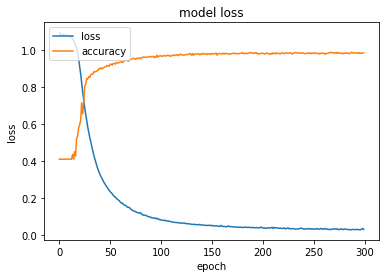

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()

In [13]:
sentence = ["kurir keren"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences,maxlen=max_length,padding=padding_type,truncating=trunc_type)
predic = np.rint(model.predict(padded))
predic2 = model.predict(padded)
print(predic)
print(predic2)

[[0. 1. 0.]]
[[0.13933793 0.6492219  0.3614248 ]]


In [36]:
import numpy as np

y_label = {0:"negative",1:"neutral",2:"positive"}

prediction = np.array(predic)
print(y_label[np.argmax(prediction)])


neutral


In [81]:
data_predict = pd.read_excel("data clear.xlsx")
data_predict = data_predict.dropna()
data_predict.head()
data_predict.isna().sum()

text    0
dtype: int64

In [87]:
new = data_predict.values.tolist()

In [88]:
sequences = tokenizer.texts_to_sequences(new)
padded = pad_sequences(sequences,maxlen=max_length,padding=padding_type,truncating=trunc_type)
data_prediction = model.predict(padded)
padded

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [72]:
for x in data_prediction:
    np.array(x)
    print(y_label[np.argmax(prediction)])



neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
neutral
